In [1]:
import sys
import os

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import numpy as np

sys.path.append(os.getcwd())
from load_data import *
from plotting_tools import *

sys.path.append('../3_score/')
from optimize import Scores

In [2]:
receptor = 'MAP4K4'#AR B2AR CDK2 CHK1 HSP90 LPXC TRMD

data_set_dir = '/scratch/PI/rondror/docking_data/'+receptor+'/'
   
rmsd_file = 'rmsd.csv'
glide_dir = data_set_dir + 'glide/'
crystal_fp_file = data_set_dir + '/ifp/crystal_ifp_3/ifp.fp'
docking_fp_dir = data_set_dir + '/ifp/glide_ifp_3/'

xrmsd_file = 'xrmsd.csv'
xglide_dir = data_set_dir + 'xglide/'
xdocking_fp_dir = data_set_dir + '/ifp/xglide_ifp_3/'

In [ ]:
def refine_poses(glides):
    # glides maps [lig][struct] to ligands
    # goal: output poses. map [lig] to all poses, ordered by gscore
    poses = {}
    for lig in glides.keys():
        poses[lig] = []
        for struct in glides[lig].keys():
            if lig == struct: continue
            p = glides[lig][struct].poses
            poses[lig].extend([p[i] for i in p.keys()])
        poses[lig].sort(key=lambda x: x.gscore)
    return poses    

In [5]:
## useful class specifications:
# Ligand -- attributes: crystal (currently not used/none), poses (dict of pose_num:pose).
# Pose -- attributes: rmsd (float), fp (Fingerprint, num (integer), gscore (float)
# FuzzyFingerPrint -- attributes: pdb, feats (dict of residue name:interaction list).

# crystals: maps structures to Poses, 
#           e.g., crystals['4LDO'] = Pose(rmsd=0, fingerprint, num=0, gscore=0)
# glides:   maps ligand_struct, grid_struct to Ligands, 
#           e.g., glides['4LDO']['4LDO'] = Ligand(...)

## STEP 1:
## load in the crystal structures, docking results, and fingerprints

w1 = [10,10,10,1,0,0,0]
w2 = [10,10,10,1,0]

#(all_crystals, all_glides) = load_data(
#    data_set_dir, rmsd_file, glide_dir, crystal_fp_file, docking_fp_dir,w=w2)
(all_xcrystals, all_xglides) = load_data(
    data_set_dir, xrmsd_file, xglide_dir, crystal_fp_file, xdocking_fp_dir,w=[10,10,10,1,0])

Loading crystal structures...
Crystal structure fingerprint file not found.
Loading glidescores...
0 of 60 total pairs failed to dock.
Loading fingerprints...
Glide fingerprint directory not found.
Loading docking results...


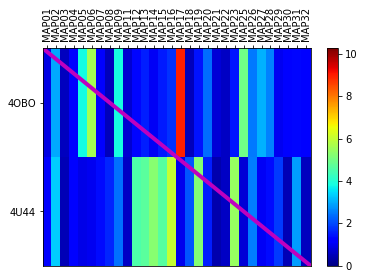

2.1753


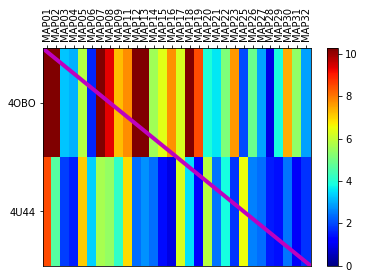

In [10]:
## STEP 2:
## visualize docking results

# in the heatmaps, each row is a structure and each column is a ligand

ligs = sorted(all_xglides.keys())#['4LDL','4LDO','4QKX'] # ['3P0G','4LDL','4LDO','4QKX','3PDS']
structs = ['4OBO','4U44']

xglides = {l:{s:all_xglides[l][s] for s in all_xglides[l] if s in structs} for l in all_xglides if l in ligs}
xcrystals = {s:all_xcrystals[s] for s in all_xcrystals if s in structs}

get_ipython().magic(u'matplotlib inline')

best_rmsd_matrix = best_pose(ligs, structs, xglides, 25)
heatmap(best_rmsd_matrix, ligs, structs)
print np.nanmean(best_rmsd_matrix)

var_mat = docking_variance(ligs, structs, xglides, 25)
heatmap(var_mat, ligs, structs)

#luck = 0
#total = 0
#for l in glides.keys():
#    for s in glides.keys():
#        total += 1
#        p = [glides[l][s].poses[i].rmsd for i in range(50) if i < len(glides[l][s].poses)]
#        if np.mean(p) < 2 and np.var(p) < 1:
#            luck += 1
            #print 'lig, struct: ', l, s
            #print 'mean: ', np.mean(p)
            #print 'var: ', np.var(p)
            
#print luck, total

In [ ]:
get_ipython().magic(u'matplotlib inline')

for lig in ligs:
    print lig
    for struct in structs:
        if struct not in xglides[lig]: continue
        #print 'lig, struct: ', lig, struct
        poses = xglides[lig][struct].poses
        pnum = [i for i in poses.keys()]
        g1 = [i for i in poses.keys()]
        rmsd = [poses[i].rmsd for i in poses.keys()]
        plt.plot(g1[:25], rmsd[:25], '.', markersize=10)
        #plt.plot(rmsd[:50], 'b.', markersize=10)
        #print 'rmsd mean (blue): ', np.mean(rmsd[:50])
        #print 'rmsd var (blue): ', np.var(rmsd[:50])
        #if struct in xglides[lig].keys():
        #    p2 = xglides[lig][struct].poses
        #    pnum2 = [i for i in p2.keys()]
        #    g2 = [i for i in p2.keys()]
        #    r2 = [p2[i].rmsd for i in p2.keys()]
        #    plt.plot(g2[:25],r2[:25], 'b.', markersize=10)
            #plt.plot(r2[:50], 'r.', markersize=10)
            #print 'rmsd mean (red): ', np.mean(r2[:25])
            #print 'rmsd var (red): ', np.var(r2[:25])
            
    plt.gca().set_ylim([0,15])
    plt.gca().set_xlim([0,25])
    plt.show()

In [ ]:
## STEP 4:
## score all pairs of ligands
print glides.keys()
best_rmsd_matrix = best_pose(glides.keys(), glides.keys(), glides, 50)
best_rmsd_matrix2 = best_pose(xglides.keys(), xglides.keys(), xglides, 25)

for best_structure in glides.keys():#filtered_ligands:
    print best_structure
    
    struct_ind = glides.keys().index(best_structure)
    filtered_ligands = ligs#[glides.keys()[i] for i in range(len(glides.keys())) if not np.isnan(best_rmsd_matrix[struct_ind][i])]
    #print filtered_ligands, glides.keys(), crystals.keys()
    #struct_ind2 = xglides.keys().index(best_structure)
    #filtered_ligands2 = [xglides.keys()[i] for i in range(len(xglides.keys())) if not np.isnan(best_rmsd_matrix2[struct_ind2][i])]
    
    scores = Scores(glides, crystals, filtered_ligands, best_structure, 50)
    scores2 = Scores(xglides, xcrystals, filtered_ligands, best_structure, 25)
    final_rmsds = plot_final_rmsds(scores2, receptor+' docked to: '+best_structure, scores,'old dock: ')
    
    #plot_magnitudes(scores, receptor)
    #plot_magnitudes(scores2, receptor)
    #for lig in ligs:
    #    plot_scores_vs_rmsds(lig, scores2, lab=lig, scores2=scores, lab2='old dock')

In [ ]:
(l1,l2,l3) = ('4FSW','4FSZ','4FT0')#tuple(ligs)[:3]
for struct in ['4FT0']:#structs[3:6]:
    for p1 in range(25):
        print p1
        f1 = xglides[l1][struct].poses[p1]
        for p2 in range(25):
            f2 = xglides[l2][struct].poses[p2]
            for p3 in range(25):
                f3 = xglides[l3][struct].poses[p3]
                score = scores.score_pose_pair(f1.fp,f2.fp)+scores.score_pose_pair(f3.fp,f2.fp)+scores.score_pose_pair(f1.fp,f3.fp)
                r = (f1.rmsd+f2.rmsd+f3.rmsd)/3
                plt.plot([r],[score],'.k')
    plt.show()

In [ ]:
(l1,l2,l3) = tuple(ligs)
for struct in structs:
    fig, ax = plt.subplots()
    print struct
    for p1 in range(25):
        print p1
        f1 = glides[l1][struct].poses[p1]
        for p2 in range(25):
            f2 = glides[l2][struct].poses[p2]
            s1 = scores.score_pose_pair(f1.fp,f2.fp)
            for p3 in range(25):
                f3 = glides[l3][struct].poses[p3]
                score = s1+scores.score_pose_pair(f3.fp,f2.fp)+scores.score_pose_pair(f1.fp,f3.fp)
                r = (f1.rmsd+f2.rmsd+f3.rmsd)/3
                plt.plot([r],[score],'.k')
                ax.set_title(struct+' struct objective')

    plt.show()

In [ ]:
for struct in 
plot_magnitudes(scores2, receptor)
#scores2 = Scores(xglides, xcrystals, filtered_ligands, best_structure, 25)

In [ ]:
(worst_lig, worst_rmsd, b, c) = final_rmsds[np.argmax([i[1] for i in final_rmsds])]
print worst_lig, worst_rmsd, b, c

In [ ]:
#worst_lig = '4YKU'

for worst_lig in ['4YKY']:#filtered_ligands:
    print worst_lig
    final_scores = scores2.get_final_scores(worst_lig)[:-1]
    rmsds = scores2.get_rmsds(worst_lig)[:-1]

    top_pose = np.argmax(final_scores)
    best_pose = np.argmin(rmsds)

    print 'Top pose: ' + str(top_pose) + '. Score: ' + str(final_scores[top_pose]) + '. RMSD: ' + str(rmsds[top_pose])
    print 'Best pose: ' + str(best_pose) + '. Score: ' + str(final_scores[best_pose]) + '. RMSD: ' + str(rmsds[best_pose])
    print 'Crystal pose score: ' + str(scores.get_final_scores(worst_lig)[-1])

#print rmsds
#print [glides[worst_lig][best_structure].poses[i].rmsd for i in range(50)]

In [ ]:
#worst_lig='4FSW'

## STEP 6:
## look at the final scores for all poses of the worst ligand

## for our method to work repeatably and reliably,
## there needs to be a strong correlation in these plots

plot_scores_vs_rmsds(worst_lig, scores2, lab=worst_lig)#, scores2=scores2, lab2='new h')

In [ ]:
fp = glides[worst_lig][best_structure].poses[best_pose].fp.feats

for res in sorted(map(int,fp.keys())):
    thresh = [i**2 if i**2 > 0.1 else 0 for i in fp[str(res)]]
    if any(thresh):
        print res, thresh

In [ ]:
fp = glides[worst_lig][best_structure].poses[top_pose].fp.feats

for res in sorted(map(int,fp.keys())):
    thresh = [i**2 if i**2 > 0.1 else 0 for i in fp[str(res)]]
    if any(thresh):
        print res, thresh

In [ ]:
fp = crystals[worst_lig].fp.feats

for res in sorted(fp.keys()):
    print res, [i if abs(i) > 0.1 else 0 for i in fp[res]]

In [ ]:
## STEP 3:
## pick 1 receptor structure to use for all ligands
## filter ligands that are poorly docked

#rmsd_filter = lambda x: x < 2
#best_structure, filtered_ligands, ave_rmsd = get_structure_and_ligands(best_rmsd_matrix, rmsd_filter, glides.keys())
#print best_structure
best_structure = '4YKQ'#highest_diam_ligand
struct_ind = glides.keys().index(best_structure)
filtered_ligands = [glides.keys()[i] for i in range(len(glides.keys())) if not np.isnan(best_rmsd_matrix[struct_ind][i])]

struct_ind2 = xglides.keys().index(best_structure)
filtered_ligands2 = [xglides.keys()[i] for i in range(len(xglides.keys())) if not np.isnan(best_rmsd_matrix[struct_ind2][i])]

print 'The best structure is ' + best_structure
print str(len(filtered_ligands)) + ' of ' + str(len(glides.keys())) + ' ligands were docked:'
print filtered_ligands
print 'with an average best rmsd of ' + str(np.nanmean(best_rmsd_matrix))[:5]

In [ ]:
## STEP 7: 
## look through pairs involving worst_lig

l1 = worst_lig
#(l2, next_worst_rmsd, b, c) = final_rmsds[np.argmax([i[1] if i[1] != worst_rmsd else 0 for i in final_rmsds])]
l2 = '3V49'
print l1, l2

In [ ]:
## STEP 8: debug the worst pair

get_ipython().magic(u'matplotlib inline')

plot_all_poses(l1, l2, scores2, l1 + ' ' + l2)#, scores2, 'new')

In [ ]:
## use this block to extract interesting pairs from the plot above

# l1 pose num, l2 pose num, rmsd1, rmsd2, score

bad_rmsd = lambda r1,r2: (r1+r2)/2.0 >= 2
good_rmsd = lambda r1,r2: (r1+r2)/2.0 <= 2
good_score = lambda score: score >= 50
combo = lambda rmsd, score: score and rmsd

# output: p1, p2, r1, r2, score(p1,p2)
bad_pairs = scores.get_filtered_pose_pairs(l1, l2, bad_rmsd, good_score, combo)
bad_pairs.sort(key=lambda x: x[4])
bad_pairs.reverse()

good_pairs = scores.get_filtered_pose_pairs(l1, l2, good_rmsd, good_score, combo)
good_pairs.sort(key=lambda x: x[4])
good_pairs.reverse()

print l1, l2
print 'Bad pairs:'
for i in range(min(5, len(bad_pairs))):
    print bad_pairs[i]
print 'Good pairs:'
for i in range(min(5, len(good_pairs))):
    print good_pairs[i]

In [ ]:
(bad_score,  bad_interactions)  = scores.get_interactions(l1, l2, bad_pairs[0][0],  bad_pairs[0][1])
(good_score, good_interactions) = scores.get_interactions(l1, l2, good_pairs[0][0], good_pairs[0][1])
(true_score, true_interactions) = scores.get_interactions(l1, l2, -1, -1)

# returns list of tuples: (arg1_strength - arg2_strenth, res, interaction_type)
explore_1 = scores.find_mismatched_interactions(true_interactions, good_interactions)
explore_2 = scores.find_mismatched_interactions(true_interactions, bad_interactions)

explore_1.sort(key=lambda x: abs(x[0]), reverse=True) # sort on absolute value of the mismatch
explore_2.sort(key=lambda x: x[0])

print 'Biggest mismatches between the good pose and the crystal pose'
for i in range(10):
    print explore_1[i]
print '--------'
print 'Biggest negative mismatches between the bad pose and the crystal pose'
for i in range(10):
    print explore_2[i]

In [ ]:
#print crystals.keys()
for res in crystals['3V4A'].fp.feats.keys():
    print res, [i if abs(i) > .01 else 0 for i in crystals['3V4A'].fp.feats[res]]